In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [3]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [22]:
sgn = SciGRID_network()

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [23]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [24]:
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

bus_diff_cov_solar = solar_diff_cov

In [25]:
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T

line_diff_cov_solar = sgn.F @ bus_diff_cov_solar @ sgn.F.T

In [26]:
armafits = ARMAfit_loader(sgn)

In [27]:
# sgn_fullyear = SciGRID_network()
# sgn_fullyear.network.generators_t.p_max_pu
# sgn2.network.generators_t.p_max_pu

In [28]:
printm("## `sgn`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits.wind_generationmonth.sum(axis=0).mean()))

## `sgn`:

Average national solar generation: 3170 MW

Average national wind generation: 10805 MW

In [29]:
sgn2= SciGRID_network(Path(pypsapath) / "examples" / "scigrid-de" / "scigrid-with-load-gen-trafos")
armafits2 = ARMAfit_loader(sgn2)

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [12]:
printm("## `sgn2`:")
printm("Average national solar generation: {0:.0f} MW".format(armafits2.solar_generationmonth.sum(axis=0).mean()))
printm("Average national wind generation: {0:.0f} MW".format(armafits2.wind_generationmonth.sum(axis=0).mean()))

## `sgn2`:

Average national solar generation: 1975 MW

Average national wind generation: 22621 MW

In [31]:
sgn_jan1 = sgn.solar_generation[:,:24]
sgn2_jan1 = sgn2.solar_generation[:,:24]
coincide = np.all(sgn_jan1 == sgn2_jan1)

printm("`sgn` and `sgn2` **{}** coincide on January 1, 2011.".format("DO" if coincide else "DO NOT"))

`sgn` and `sgn2` **DO** coincide on January 1, 2011.

# 🌼

In [33]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:59<00:00,  9.64s/it]


In [ ]:
sgn2.run_lopf_jan1()

In [35]:
sgn2_line_flow_jan1 = sgn2.line_flow_linear.values
sgn_line_flow_jan1 = sgn.line_flow_linear.values
coincide_line_flow = np.all(sgn2_line_flow_jan1 == sgn_line_flow_jan1)

printm("`sgn2` and `sgn` line flows **{}** coincide on January 1, 2011.".format("DO" if coincide_line_flow else "DO NOT"))

`sgn2` and `sgn` line flows **DO NOT** coincide on January 1, 2011.

# 🌷

In [34]:
fav_sgn = sgn

In [35]:
elevenAM = fav_sgn.network.generators_t.p.index[11]

print(f"Total load: {fav_sgn.network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {fav_sgn.network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {fav_sgn.injection_total.loc[elevenAM,:].sum()} MW")

Total load: 52524.64000000083 MW
Total generation: 52950.84000000398 MW
Generation overshoot: 426.20000000314803 MW


In [41]:
#pd.Series(sgn2.line_saturation_total.values[11])
#sgn2.network.lines_t.p1.values[11]# / sgn2.network.lines.s_nom
#sgn2.line_flow_total

next(i for i,names in enumerate(sgn.scigrid_line_indices) if "4" in names)

3

In [42]:
fav_sgn.reload()

f = fav_sgn.line_saturation_nonlinear.values[11,:]

def true_prob(mu_l, sigma_l):
    return 1.0 - (scipy.stats.norm.cdf(1.0, loc=mu_l, scale=sigma_l) - scipy.stats.norm.cdf(-1.0, loc=mu_l, scale=sigma_l))

def rate(mu_l, sigma_l):
    return np.square(1-np.abs(mu_l))/(2.0*np.square(sigma_l))

line_ratings = pd.DataFrame({"l":fav_sgn.scigrid_line_indices,
              "f": f,
              "σdiff_day": np.sqrt(np.diagonal(line_diff_cov_day)) / fav_sgn.line_threshold})

sigmaepsilon = 1
line_ratings["P>1"] = true_prob(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)
line_ratings["rate"] = rate(line_ratings.f, line_ratings.σdiff_day*sigmaepsilon)

line_ratings["Pnorm"] = line_ratings["P>1"] / np.max(line_ratings["P>1"])

line_ratings.sort_values("P>1", ascending=False).head(20)

0.13.2 ['C:/dev/py/PyPSA\\pypsa']


,l,f,σdiff_day,P>1,rate,Pnorm
651,[809],0.700000,0.229494,0.095568,0.854420,1.000000
652,[810],-0.681245,0.237297,0.089591,0.902194,0.937463
411,[516],-0.700000,0.203939,0.070642,1.081965,0.739175
54,[58],0.614813,0.250550,0.062102,1.181745,0.649820
298,[361],-0.700000,0.165036,0.034548,1.652178,0.361504
473,[584],0.370513,0.338016,0.031306,1.734079,0.327574
213,[249],-0.700000,0.151372,0.023747,1.963915,0.248479
25,[27],-0.700000,0.147734,0.021144,2.061833,0.221242
645,[803],-0.700000,0.146402,0.020223,2.099520,0.211613
74,[80],-0.429590,0.276626,0.019603,2.125974,0.205119


(array([166., 121.,  95.,  63.,  51.,  46.,  32.,  34.,  19.,  13.,   7.,
          9.,   9.,  30.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

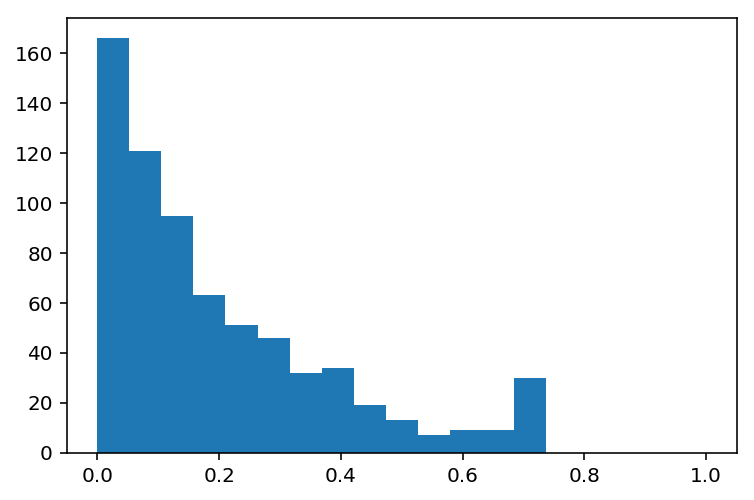

In [43]:
plt.hist(np.abs(f), bins=np.linspace(0,1,num=20))

Text(0, 0.5, 'length')

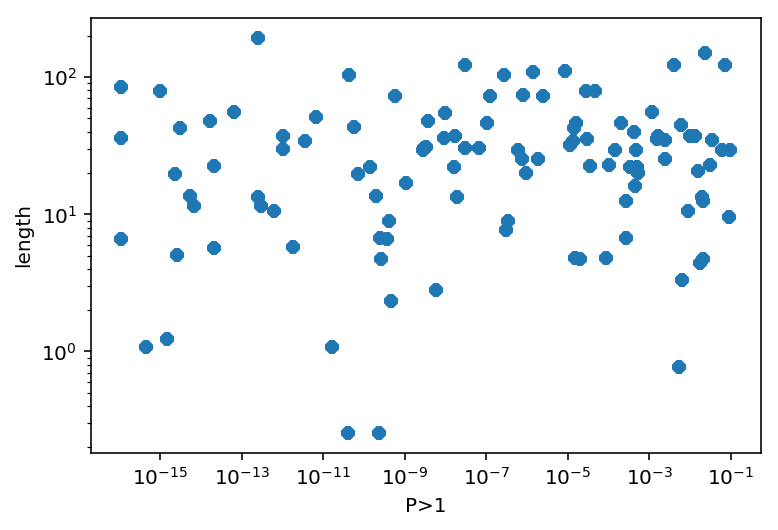

In [61]:
fig, ax = plt.subplots()


ax.set_xscale("log")
ax.set_yscale("log")

p = line_ratings["P>1"]
lengths = np.array(fav_sgn.line_lengths)

ax.plot(p[p>0], lengths[p>0], "8")
ax.set_xlabel("P>1")
ax.set_ylabel("length")

In [49]:
def most_likely_power_injection_given_line_failure(l):
    mup = fav_sgn.injection_total.loc[elevenAM]
    muf = fav_sgn.line_saturation_nonlinear.loc[elevenAM] # should be line_saturation_linear to be mathematically correct
    
    sigmap = bus_diff_cov_day
    sigmaf = (line_diff_cov_day * (1.0/fav_sgn.line_threshold)) * ((1.0/fav_sgn.line_threshold)[:,np.newaxis])
    
    def sign_mod(x):
        """The regular sign function, with the modification that `sign_mod(0.0)==1.0`, instead of zero."""
        return 1.0 if x >= 0.0 else -1.0
    
    return mup + (sign_mod(muf[l]) - muf[l]) / sigmaf[l,l] * (sigmap @ (fav_sgn.F[l] / fav_sgn.line_threshold[l]))
    

In [74]:
l = 251


avg_dev = np.mean(np.abs(most_likely_power_injection_given_line_failure(l) - fav_sgn.injection_total.loc[elevenAM]))
avg_injection = np.mean(np.abs(fav_sgn.injection_total.loc[elevenAM]))

printm("Deviation is {:.0f}% of average injection.".format(100 * avg_dev / avg_injection))
pd.Series(np.abs(most_likely_power_injection_given_line_failure(l) - fav_sgn.injection_total.loc[elevenAM])).describe()

printm("Line is {} km.".format(fav_sgn.line_lengths[l]))

Deviation is 12% of average injection.

Line is 20.646 km.

In [75]:
pd.Series((fav_sgn.F @ most_likely_power_injection_given_line_failure(l)) / fav_sgn.line_threshold).describe()

count    695.000000
mean      -0.004598
std        0.356584
min       -1.407744
25%       -0.164744
50%        0.000442
75%        0.173257
max        1.891635
dtype: float64

Line is 79.19 km


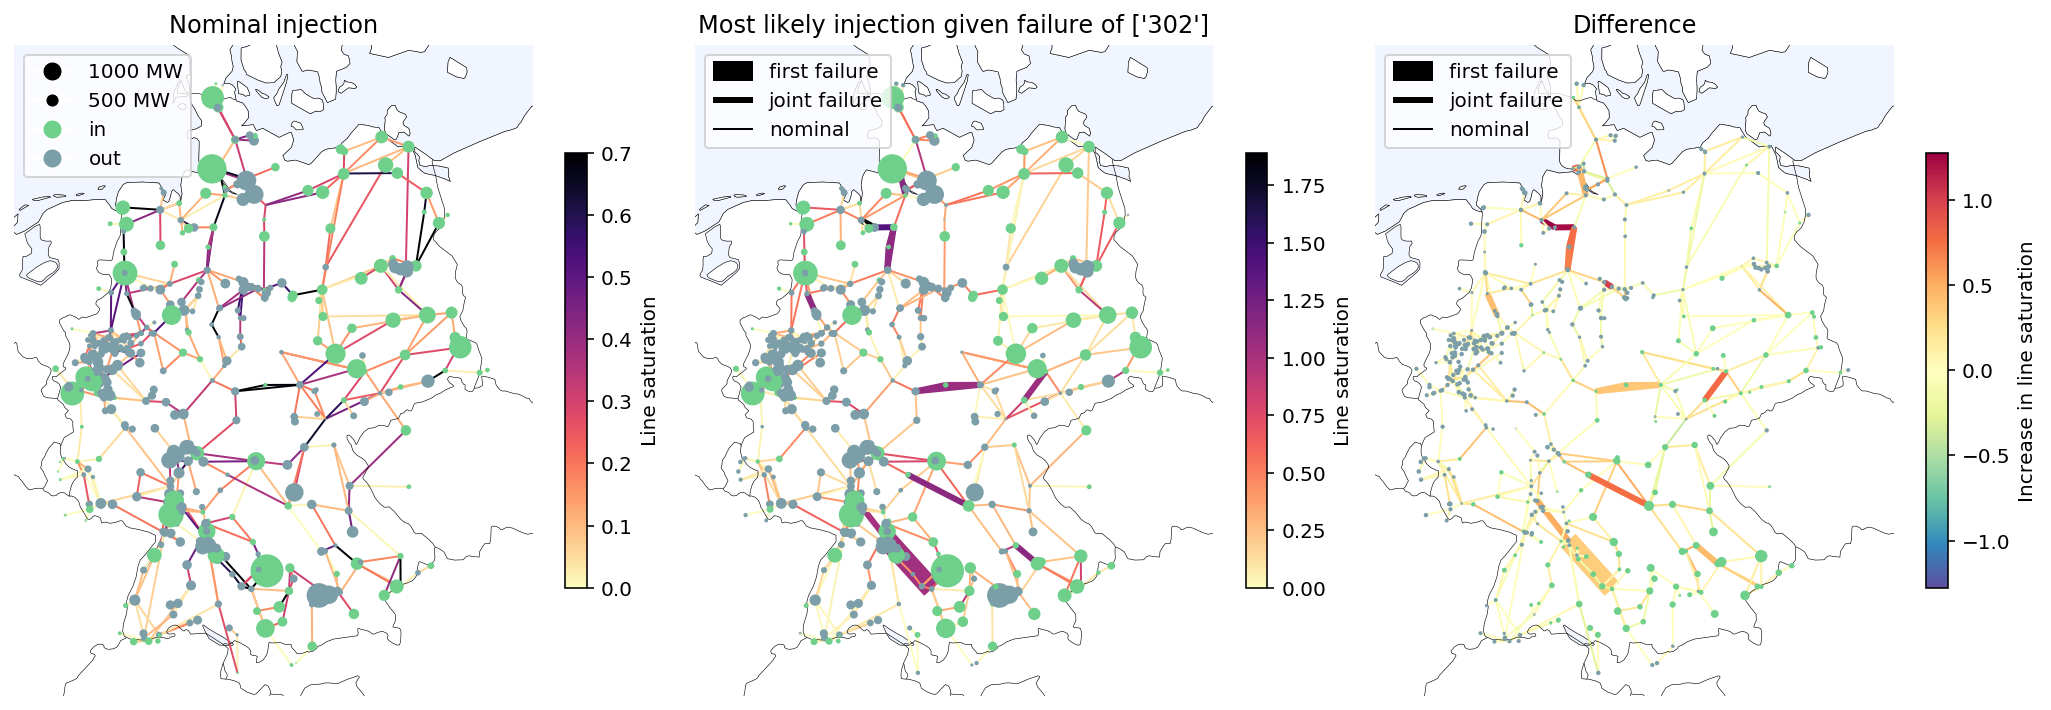

In [113]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


import cartopy.feature

# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_ratings["f"]))
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")
ax[0].set_title("Nominal injection")


# --

p_given_l = most_likely_power_injection_given_line_failure(l)
p_given_l -= np.mean(p_given_l)
colors = np.abs(fav_sgn.F @ p_given_l) / fav_sgn.line_threshold
widths = np.ones(fav_sgn.m)
widths[np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) >= 1.0] = 3
widths[l] = 10

bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(p_given_l)
line_colors, line_widths = fav_sgn.line_array_to_plot(colors, widths)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Line saturation")
linecol.set_clim(0,np.max([1.0, np.max(line_colors)]))
ax[1].set_title("Most likely injection given failure of {}".format(line_ratings.l[l]))

# --

#line_colors = np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold - fav_sgn.line_saturation_nonlinear.loc[elevenAM])
colors = np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) - np.abs(fav_sgn.line_saturation_nonlinear.loc[elevenAM])
widths = np.ones(fav_sgn.m)
widths[np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) >= 1.0] = 3
widths[l] = 10
#bus_sizes=0

bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(p_given_l - fav_sgn.injection_total.loc[elevenAM])
line_colors, line_widths = fav_sgn.line_array_to_plot(colors, widths)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="Spectral_r", ax=ax[2])
cbar = fig.colorbar(linecol, ax=ax[2], shrink=.5)
cbar.set_label("Increase in line saturation")
max_diff = np.max(np.abs(line_colors))
linecol.set_clim(-max_diff, max_diff)
ax[2].set_title("Difference")

# --

import matplotlib.lines

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1000 MW',
                          markerfacecolor='0', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='500 MW',
                          markerfacecolor='0', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='in',
                          markerfacecolor='#6fd08c', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='out',
                          markerfacecolor='#7b9ea8', markersize=(1000/10)**0.5)]

ax[0].legend(handles=legend_elements)

legend_elements = [matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=10, label="first failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=3,  label="joint failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=1,  label="nominal")]

ax[1].legend(handles=legend_elements)
ax[2].legend(handles=legend_elements)

for axi in ax:
    axi.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.3, zorder=.5)
    axi.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
    axi.background_patch.set_facecolor("#f0f5ff")

plt.subplots_adjust(wspace=.05)

print("Line is {} km".format(fav_sgn.network.lines.length.values[l]))


#plt.savefig("mostlikelyinjection520.pdf", bbox_inches="tight")

[ 3.60445172e+03  1.64722647e+03  5.09258688e+03  2.36596366e+12
  2.94292518e+12 -2.20595256e+11  4.74446817e+03 -1.98692763e+03
 -8.80839807e+02  1.73153936e+03  2.85163668e+03 -1.85722024e+03
  1.34930359e+03 -2.19640617e+11  6.26860529e+02  4.03179538e+13
  3.19632901e+13]
Loss of rank: 2
Line is 79.19 km


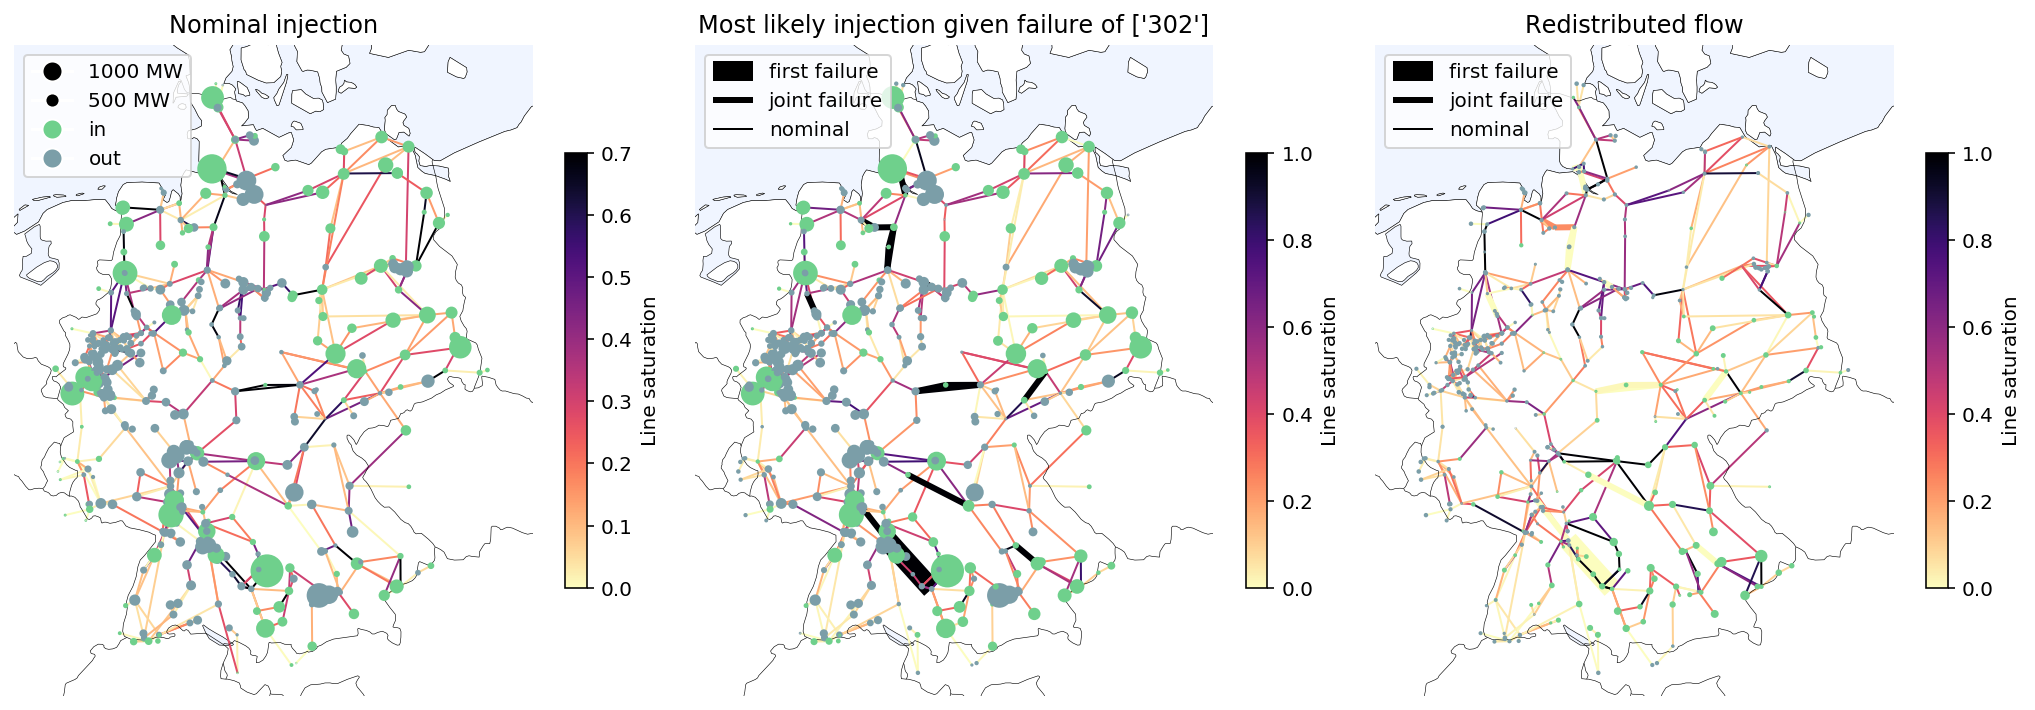

In [114]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


import cartopy.feature

# --

line_colors, line_widths = fav_sgn.line_array_to_plot(np.abs(line_ratings["f"]))
bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")
ax[0].set_title("Nominal injection")


# --

p_given_l = most_likely_power_injection_given_line_failure(l)
p_given_l -= np.mean(p_given_l)
colors = np.abs(fav_sgn.F @ p_given_l) / fav_sgn.line_threshold
widths = np.ones(fav_sgn.m)
widths[np.abs((fav_sgn.F @ p_given_l) / fav_sgn.line_threshold) >= 1.0] = 3
widths[l] = 10

bus_sizes, bus_colors = fav_sgn.bus_array_to_plot(p_given_l)
line_colors, line_widths = fav_sgn.line_array_to_plot(colors, widths)

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Line saturation")
linecol.set_clim(0.0, 1.0)
#linecol.set_clim(0,np.max([1.0, np.max(line_colors)]))
ax[1].set_title("Most likely injection given failure of {}".format(line_ratings.l[l]))

# --

failed = [i for i in range(fav_sgn.m) if colors[i]>= 1.0]

bus_sizes, bus_colors = bus_array_to_plot(p_given_l - fav_sgn.injection_total.loc[elevenAM])

colors = np.abs((f_given_l + fav_sgn.line_outage_flow_difference(failed, f_given_l)) / fav_sgn.line_threshold)
widths = np.ones(fav_sgn.m)
widths[np.abs(f_given_l / fav_sgn.line_threshold) >= 1.0] = 3
widths[l] = 10
#bus_sizes=0

line_colors, line_widths = line_array_to_plot(colors, widths)
pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors, line_widths=line_widths, line_cmap="magma_r", ax=ax[2])
cbar = fig.colorbar(linecol, ax=ax[2], shrink=.5)
cbar.set_label("Line saturation")
linecol.set_clim(0.0, 1.0)
ax[2].set_title("Redistributed flow")

import matplotlib.lines

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1000 MW',
                          markerfacecolor='0', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='500 MW',
                          markerfacecolor='0', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='in',
                          markerfacecolor='#6fd08c', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='out',
                          markerfacecolor='#7b9ea8', markersize=(1000/10)**0.5)]

ax[0].legend(handles=legend_elements)

legend_elements = [matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=10, label="first failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=3,  label="joint failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=1,  label="nominal")]

ax[1].legend(handles=legend_elements)
ax[2].legend(handles=legend_elements)

for axi in ax:
    axi.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.3, zorder=.5)
    axi.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
    axi.background_patch.set_facecolor("#f0f5ff")

plt.subplots_adjust(wspace=.05)

print("Line is {} km".format(fav_sgn.network.lines.length.values[l]))


#plt.savefig("mostlikelyinjection520.pdf", bbox_inches="tight")

In [72]:
import json
from json import encoder as jsonencoder

x = fav_sgn.locations.x
y = fav_sgn.locations.y

data_to_export = {'x' : list(x), 
                  'y' : list(y),
                  'bus0': [a for a,b in fav_sgn.new_lines], 
                  'bus1': [b for a,b in fav_sgn.new_lines], 
                  'threshold': list(fav_sgn.line_threshold),
                  'Poverload': list(line_ratings["P>1"]),
                  'mu_p': list(fav_sgn.injection_total.loc[elevenAM]),
                  'sigma_p': bus_diff_cov_day.tolist(),
                  'mu_f_norm': list(fav_sgn.line_saturation_nonlinear.loc[elevenAM]),
                  'sigma_f_norm': ((line_diff_cov_day * (1.0/fav_sgn.line_threshold)) * ((1.0/fav_sgn.line_threshold)[:,np.newaxis])).tolist(),
                  'F': fav_sgn.F.tolist()}

export_cascades = {'M': fav_sgn.M.tolist()}

with open(src.globals.data_path / "processed" / "flowandcorrelations.json","w") as f:
    json.dump(data_to_export, f, separators=(',', ':'))


with open(src.globals.data_path / "processed" / "cascades.json","w") as f:
    json.dump(export_cascades, f, separators=(',', ':'))


with open(src.globals.data_path / "processed" / "flowandcorrelations_approx.json","w") as f:
    approx = json.loads(json.dumps(data_to_export), parse_float=lambda s: float("{:.4g}".format(float(s))))
    json.dump(approx, f, separators=(',', ':'))

with open(src.globals.data_path / "processed" / "cascades_approx.json","w") as f:
    approx = json.loads(json.dumps(export_cascades), parse_float=lambda s: float("{:.4g}".format(float(s))))
    json.dump(approx, f, separators=(',', ':'))

In [104]:
fav_sgn.M

array([[ 2.22044605e-16, -4.09394740e-15,  3.28296418e-16, ...,
        -2.02095285e-16, -3.12250226e-17,  2.21177243e-16],
       [ 3.60822483e-16, -4.69000208e-01,  1.04119400e-01, ...,
        -4.92377360e-05,  8.29154738e-07, -3.71928840e-05],
       [ 8.32667268e-17,  9.59741934e-02, -6.02154394e-01, ...,
        -5.82514849e-06,  1.68431483e-07, -6.58816141e-06],
       ...,
       [-2.86957957e-14, -1.09851978e-02, -1.40991845e-03, ...,
        -3.50601740e-02,  6.60919233e-06, -1.82971859e-04],
       [ 2.49778496e-15,  1.77120295e-04,  3.90331141e-05, ...,
         6.32807073e-06, -4.42450819e-01, -2.56959302e-06],
       [-2.44249065e-15, -7.75751843e-03, -1.49074849e-03, ...,
        -1.71055663e-04, -2.50896479e-06, -1.41786719e-02]])

In [111]:
fav_sgn.line_outage_flow_difference([1], fav_sgn.line_flow_nonlinear.loc[elevenAM,:])

[-1312.59936504]


array([-5.37371276e-12, -6.15609375e+02,  1.25975665e+02,  1.87782722e+02,
       -8.50170065e+01,  1.98431043e+00,  1.98431043e+00,  2.12891934e+00,
       -2.46864971e+00, -2.58789626e+00, -4.30463618e+01,  2.05609113e+00,
       -2.05609113e+00, -1.24860275e+00,  3.80713887e-12, -3.68884315e+01,
        5.37714968e+00,  3.15112818e+01,  3.89611150e+00, -1.06930794e+00,
       -5.34137903e+00,  1.34868297e+01, -1.30948034e+01,  1.01050522e+02,
       -8.50170065e+01, -1.03067985e+01, -4.74855260e+00,  4.70762555e+00,
        1.66220776e-12,  9.51784718e-13, -2.54846644e+02,  5.82218050e+00,
       -6.59544478e+00,  6.59544478e+00,  2.94361757e+00,  5.86363889e+00,
       -5.86363889e+00,  3.30249561e+00,  1.06335757e-12, -2.20086063e-01,
        2.19199043e-01,  4.40173957e-01,  2.68344089e-12, -9.07383278e-13,
       -4.70762555e+00, -2.38131736e+01, -3.37248781e-01, -3.03854919e+00,
        9.03967782e-13, -1.71001629e+00,  1.62349881e-12,  5.27267102e-13,
        0.00000000e+00,  

[ 0.00583344 -0.0036612 ]
[ 7.48685104e-04  3.10957432e-04 -2.37374253e-03  5.14866751e-03
 -3.55903488e-02  5.14279171e+08 -3.09461140e+08 -1.84112460e-03
  6.51193101e-04  5.09245326e-05 -6.94221325e-03 -2.93610828e+08
 -2.42325723e+09  5.09042187e-05 -9.00151402e-03  2.36697736e+06
 -1.05322644e-03  3.12201958e-03  4.54266276e-03  2.75040418e-03]
Loss of rank: 1


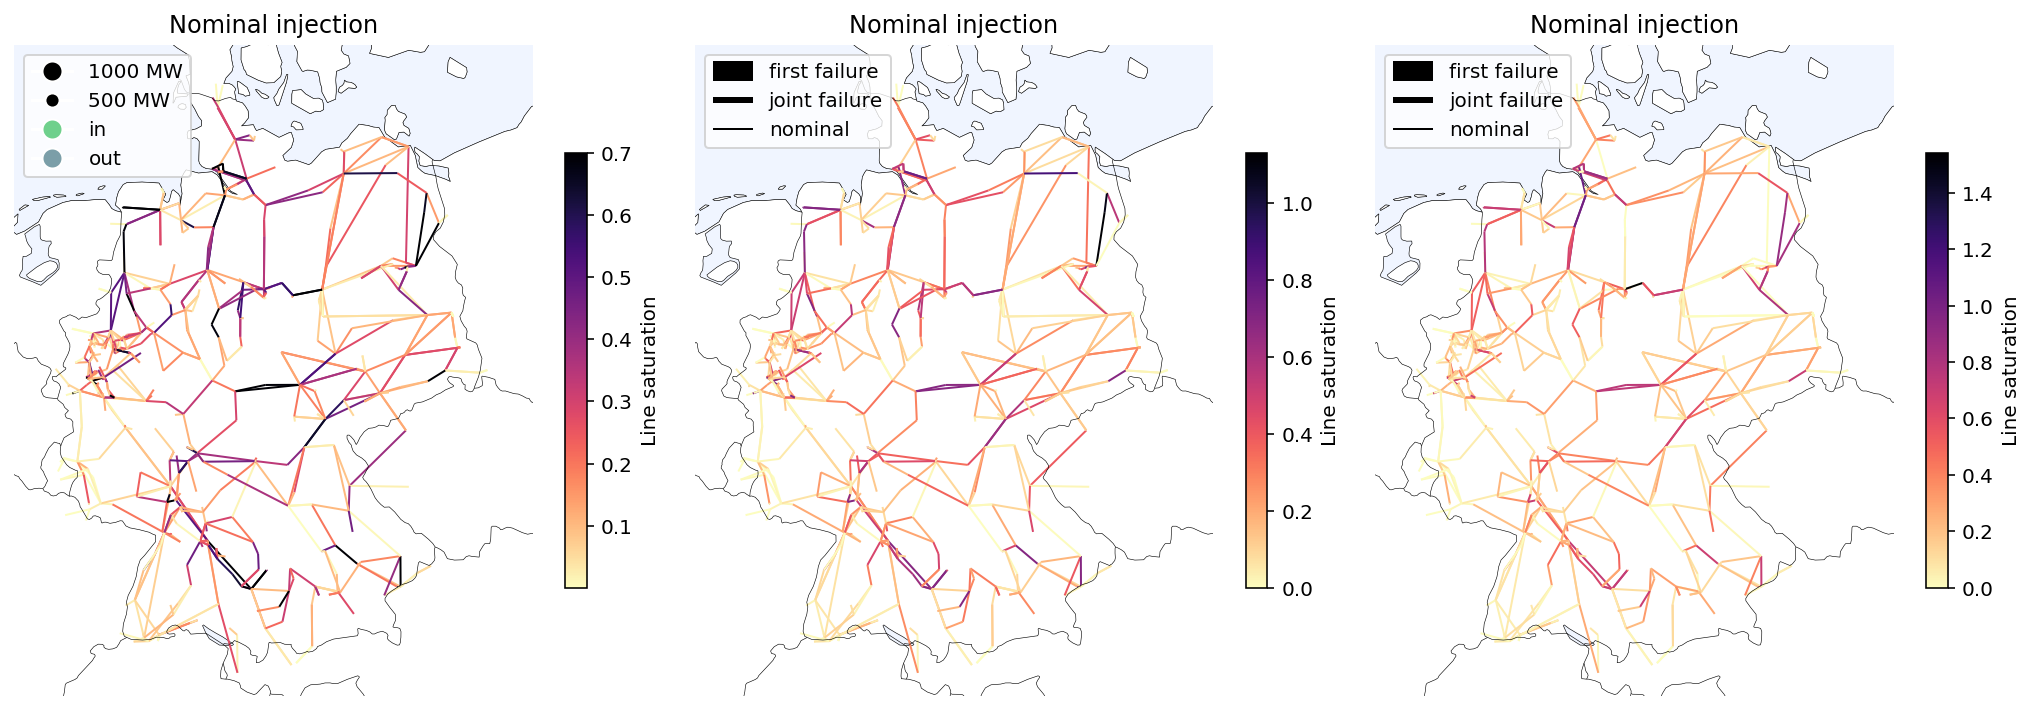

In [95]:
fig = plt.figure(figsize=(18,8))
import cartopy.crs as ccrs 
ax = fig.subplots(1,3,subplot_kw={"projection":ccrs.TransverseMercator(central_longitude=10.0, central_latitude=50.0)}).flatten()

geomap = "50m"


import cartopy.feature

def bus_array_to_plot(x):
    bus_sizes = [0]*len(fav_sgn.network.buses)
    bus_colors = ['g']*len(fav_sgn.network.buses)

    for i, bus_name in enumerate(fav_sgn.network.buses.index):
        if bus_name in fav_sgn.new_nodes:
            val = x[fav_sgn.node_index(bus_name)]
            bus_sizes[i] = np.abs(val) / 10
            bus_colors[i] = '#6fd08c' if val > 0 else '#7b9ea8'
    return bus_sizes, bus_colors


line_colors_flow = np.abs(fav_sgn.line_saturation_nonlinear.loc[elevenAM,:])
line_widths=1
bus_sizes, bus_colors = bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])
bus_sizes = 0

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors_flow, line_widths=line_widths, line_cmap="magma_r", ax=ax[0])
cbar = fig.colorbar(linecol, ax=ax[0], shrink=.5)
cbar.set_label("Line saturation")
ax[0].set_title("Nominal injection")


line_colors_flow = np.abs(fav_sgn.line_saturation_nonlinear.loc[elevenAM,:]
                         + fav_sgn.line_outage_flow_difference([20,217], fav_sgn.line_flow_nonlinear.loc[elevenAM,:]) / fav_sgn.line_threshold)
line_widths=1
bus_sizes, bus_colors = bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])
bus_sizes = 0

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors_flow, line_widths=line_widths, line_cmap="magma_r", ax=ax[1])
cbar = fig.colorbar(linecol, ax=ax[1], shrink=.5)
cbar.set_label("Line saturation")
ax[1].set_title("Nominal injection")



line_colors_flow = np.abs(fav_sgn.line_saturation_nonlinear.loc[elevenAM,:]
                         + fav_sgn.line_outage_flow_difference(list(range(20)), fav_sgn.line_flow_nonlinear.loc[elevenAM,:]) / fav_sgn.line_threshold)
line_widths=1
bus_sizes, bus_colors = bus_array_to_plot(fav_sgn.injection_total.loc[elevenAM])
bus_sizes = 0

pathcol, linecol = fav_sgn.network.plot(geomap=geomap, bus_sizes=bus_sizes, bus_colors=bus_colors, line_colors=line_colors_flow, line_widths=line_widths, line_cmap="magma_r", ax=ax[2])
cbar = fig.colorbar(linecol, ax=ax[2], shrink=.5)
cbar.set_label("Line saturation")
ax[2].set_title("Nominal injection")

import matplotlib.lines

legend_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='1000 MW',
                          markerfacecolor='0', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='500 MW',
                          markerfacecolor='0', markersize=(500/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='in',
                          markerfacecolor='#6fd08c', markersize=(1000/10)**0.5),
                   matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='out',
                          markerfacecolor='#7b9ea8', markersize=(1000/10)**0.5)]

ax[0].legend(handles=legend_elements)

legend_elements = [matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=10, label="first failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=3,  label="joint failure"),
                   matplotlib.lines.Line2D([0,1], [0,0], color="0", solid_capstyle="butt", linewidth=1,  label="nominal")]

ax[1].legend(handles=legend_elements)
ax[2].legend(handles=legend_elements)

for axi in ax:
    axi.add_feature(cartopy.feature.LAKES.with_scale(geomap), facecolor="#f0f5ff", edgecolor="#000000", linewidth=.3, zorder=.5)
    axi.add_feature(cartopy.feature.LAND.with_scale(geomap), facecolor="#ffffff", edgecolor="#000000", linewidth=.2)
    axi.background_patch.set_facecolor("#f0f5ff")

plt.subplots_adjust(wspace=.05)


#plt.savefig("mostlikelyinjection520.pdf", bbox_inches="tight")

In [158]:
fav_sgn.reload()

0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [191]:
for failed, inj in list(fav_sgn.simulate_cascade(213, bus_diff_cov_day)):
    #print(np.round((inj / fav_sgn.line_threshold)[failed], 2))
    print(sorted(failed))

[213]
[213, 651]
[213, 634, 651]
[213, 631, 634, 651]
[163, 213, 631, 634, 651]


In [175]:
%%time
for l in np.random.choice(range(fav_sgn.m), 10):
    casc = list(fav_sgn.simulate_cascade(l, bus_diff_cov_day))
    print("Line {}: {} failed in {} phases".format(l, len(casc[-1][0]), len(casc)))

Line 110: 364 failed in 7 phases
Line 353: 298 failed in 8 phases
Line 622: 354 failed in 9 phases
Line 370: 221 failed in 11 phases
Line 349: 184 failed in 8 phases
Line 241: 188 failed in 10 phases
Line 295: 234 failed in 7 phases
Line 589: 249 failed in 8 phases
Line 48: 445 failed in 9 phases
Line 102: 265 failed in 12 phases
Line 263: 428 failed in 5 phases
Line 6: 211 failed in 12 phases
Line 324: 465 failed in 6 phases
Line 66: 267 failed in 8 phases
Line 671: 469 failed in 5 phases
Line 614: 234 failed in 11 phases
Line 49: 265 failed in 8 phases
Line 498: 383 failed in 7 phases
Line 474: 368 failed in 9 phases
Line 664: 283 failed in 9 phases
Line 688: 395 failed in 8 phases
Line 112: 262 failed in 7 phases
Line 315: 31 failed in 6 phases
Line 136: 321 failed in 9 phases
Line 325: 326 failed in 7 phases
Line 22: 166 failed in 8 phases
Line 84: 230 failed in 10 phases
Line 191: 317 failed in 7 phases
Line 135: 326 failed in 9 phases
Line 332: 290 failed in 7 phases
Line 343: 23

In [190]:
fav_sgn.export_cascades_to_json(bus_diff_cov_day, filename="simulated_cascades_corrected")

 60%|████████████████████████████████████████████████                                | 417/695 [02:38<01:27,  3.16it/s]

Simulating cascade of line 418 failed with LinAlgError


100%|████████████████████████████████████████████████████████████████████████████████| 695/695 [04:42<00:00,  1.30it/s]


Writing to C:\dev\grid-analysis\data\processed\simulated_cascades_corrected.json
Writing to C:\dev\grid-analysis\data\processed\simulated_cascades_corrected_interactive.json
